In [61]:
import pandas as pd
import numpy as np
import sklearn.datasets as ds
import sklearn.preprocessing as preprocessing
import sklearn.model_selection as model_selection
import shap
shap.initjs()

import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import xgboost as xg
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pd.set_option('display.max_columns', 500)

# Leitura dos Dados

Como ainda não há nenhum dado, vou pegar um dataset arbitrário aqui

In [2]:
def load_dataset(path):
    """
    Load dataset from file.

    The target variable must be in column named "target".

    Parameters
    ----------
    path: str
        path to file

    Returns
    -------
    dataset: pd.DataFrame
    """
    data = ds.load_diabetes(as_frame=True)
    dataset = data["frame"]
    dataset.insert(0, "player_id", np.random.choice(range(1, 30), len(dataset)))

    return dataset

In [21]:
dataset = pd.read_parquet("./data/final_datasets/dataset_vaep.parquet")
dataset

,player,pos,player_age,last_time_played,last_shots_on_target,last_goals,last_touches,last_yellow_cards,last_completed_passes_perc,last_result,last_xg,last_xag,days_from_last_game,played_at_home,Season_End_Year,Wk,Team,Away,Capacity,tavg,tmin,tmax,prcp,snow,wspd,wpgt,travel_distance,target
0,Ainsley Maitland-Niles,LM,23,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,14.0,False,2021,1,Fulham,Arsenal,25700,16.2,11.7,21.3,0.3,0.0,14.3,31.5,5748.416939,0.442736
1,Alexandre Lacazette,FW,29,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,14.0,False,2021,1,Fulham,Arsenal,25700,16.2,11.7,21.3,0.3,0.0,14.3,31.5,5748.416939,0.498623
2,Dani Ceballos,CM,24,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,14.0,False,2021,1,Fulham,Arsenal,25700,16.2,11.7,21.3,0.3,0.0,14.3,31.5,5748.416939,0.006840
3,Eddie Nketiah,FW,21,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,14.0,False,2021,1,Fulham,Arsenal,25700,16.2,11.7,21.3,0.3,0.0,14.3,31.5,5748.416939,0.007416
4,Granit Xhaka,CM,27,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,14.0,False,2021,1,Fulham,Arsenal,25700,16.2,11.7,21.3,0.3,0.0,14.3,31.5,5748.416939,0.418577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6884,Joao Moutinho,CM,34,79.0,0.0,0.0,83.0,0.0,76.0,lose,0.0,0.1,3.0,False,2022,3,Wolves,Manchester Utd,27828,14.4,10.7,19.2,0.0,0.0,10.8,24.1,194.088306,0.098399
6885,Leander Dendoncker,CM,26,11.0,0.0,0.0,10.0,0.0,100.0,lose,0.0,0.0,3.0,False,2022,3,Wolves,Manchester Utd,27828,14.4,10.7,19.2,0.0,0.0,10.8,24.1,194.088306,0.194685
6886,Morgan Gibbs-White,CM,21,67.0,1.0,0.0,38.0,0.0,85.2,lose,0.1,0.0,3.0,False,2022,3,Wolves,Manchester Utd,27828,14.4,10.7,19.2,0.0,0.0,10.8,24.1,194.088306,0.136599
6887,Ruben Neves,CM,24,90.0,0.0,0.0,91.0,1.0,86.3,lose,0.0,0.0,3.0,False,2022,3,Wolves,Manchester Utd,27828,14.4,10.7,19.2,0.0,0.0,10.8,24.1,194.088306,0.085313


In [22]:
dataset.drop(["Season_End_Year", "Team", "Away"], axis=1, inplace=True)
dataset

,player,pos,player_age,last_time_played,last_shots_on_target,last_goals,last_touches,last_yellow_cards,last_completed_passes_perc,last_result,last_xg,last_xag,days_from_last_game,played_at_home,Wk,Capacity,tavg,tmin,tmax,prcp,snow,wspd,wpgt,travel_distance,target
0,Ainsley Maitland-Niles,LM,23,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,14.0,False,1,25700,16.2,11.7,21.3,0.3,0.0,14.3,31.5,5748.416939,0.442736
1,Alexandre Lacazette,FW,29,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,14.0,False,1,25700,16.2,11.7,21.3,0.3,0.0,14.3,31.5,5748.416939,0.498623
2,Dani Ceballos,CM,24,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,14.0,False,1,25700,16.2,11.7,21.3,0.3,0.0,14.3,31.5,5748.416939,0.006840
3,Eddie Nketiah,FW,21,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,14.0,False,1,25700,16.2,11.7,21.3,0.3,0.0,14.3,31.5,5748.416939,0.007416
4,Granit Xhaka,CM,27,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,14.0,False,1,25700,16.2,11.7,21.3,0.3,0.0,14.3,31.5,5748.416939,0.418577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6884,Joao Moutinho,CM,34,79.0,0.0,0.0,83.0,0.0,76.0,lose,0.0,0.1,3.0,False,3,27828,14.4,10.7,19.2,0.0,0.0,10.8,24.1,194.088306,0.098399
6885,Leander Dendoncker,CM,26,11.0,0.0,0.0,10.0,0.0,100.0,lose,0.0,0.0,3.0,False,3,27828,14.4,10.7,19.2,0.0,0.0,10.8,24.1,194.088306,0.194685
6886,Morgan Gibbs-White,CM,21,67.0,1.0,0.0,38.0,0.0,85.2,lose,0.1,0.0,3.0,False,3,27828,14.4,10.7,19.2,0.0,0.0,10.8,24.1,194.088306,0.136599
6887,Ruben Neves,CM,24,90.0,0.0,0.0,91.0,1.0,86.3,lose,0.0,0.0,3.0,False,3,27828,14.4,10.7,19.2,0.0,0.0,10.8,24.1,194.088306,0.085313


# Transformação de Features Categóricos em Numéricos

In [23]:
def categorical_to_one_hot_encoding(dataset, categorical_columns):
    """
    Convert categorical columns to one hot encoding.

    Parameters
    ----------
    dataset : pd.DataFrame
        The dataset to be converted.
    categorical_columns : list
        The list of categorical columns.

    Returns
    -------
    dataset_converted : pd.DataFrame
        The converted dataset.
    """
    dataset_converted = dataset.copy()
    for column in categorical_columns:
        dataset_converted = pd.concat([dataset_converted, pd.get_dummies(dataset_converted[column], prefix=column, dtype=float)], axis=1)
        dataset_converted.drop(column, axis=1, inplace=True)

    return dataset_converted

In [28]:
dataset_converted = categorical_to_one_hot_encoding(dataset, categorical_columns=["pos", "played_at_home", "last_result"])
dataset_converted

,player,player_age,last_time_played,last_shots_on_target,last_goals,last_touches,last_yellow_cards,last_completed_passes_perc,last_xg,last_xag,days_from_last_game,Wk,Capacity,tavg,tmin,tmax,prcp,snow,wspd,wpgt,travel_distance,target,pos_AM,pos_CM,pos_FW,pos_LM,pos_LW,pos_RM,pos_RW,played_at_home_False,played_at_home_True,last_result_0,last_result_draw,last_result_lose,last_result_win
0,Ainsley Maitland-Niles,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,1,25700,16.2,11.7,21.3,0.3,0.0,14.3,31.5,5748.416939,0.442736,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,Alexandre Lacazette,29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,1,25700,16.2,11.7,21.3,0.3,0.0,14.3,31.5,5748.416939,0.498623,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,Dani Ceballos,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,1,25700,16.2,11.7,21.3,0.3,0.0,14.3,31.5,5748.416939,0.006840,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,Eddie Nketiah,21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,1,25700,16.2,11.7,21.3,0.3,0.0,14.3,31.5,5748.416939,0.007416,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,Granit Xhaka,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,1,25700,16.2,11.7,21.3,0.3,0.0,14.3,31.5,5748.416939,0.418577,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6884,Joao Moutinho,34,79.0,0.0,0.0,83.0,0.0,76.0,0.0,0.1,3.0,3,27828,14.4,10.7,19.2,0.0,0.0,10.8,24.1,194.088306,0.098399,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
6885,Leander Dendoncker,26,11.0,0.0,0.0,10.0,0.0,100.0,0.0,0.0,3.0,3,27828,14.4,10.7,19.2,0.0,0.0,10.8,24.1,194.088306,0.194685,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
6886,Morgan Gibbs-White,21,67.0,1.0,0.0,38.0,0.0,85.2,0.1,0.0,3.0,3,27828,14.4,10.7,19.2,0.0,0.0,10.8,24.1,194.088306,0.136599,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
6887,Ruben Neves,24,90.0,0.0,0.0,91.0,1.0,86.3,0.0,0.0,3.0,3,27828,14.4,10.7,19.2,0.0,0.0,10.8,24.1,194.088306,0.085313,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


# Divisão do Dataset entre Treino e Teste

In [29]:
def split_dataset(dataset, test_percentage):
    """
    Splits dataset into training data and test data

    Parameters
    ----------
    dataset : pd.DataFrame
        Dataset to split
    test_percentage : float
        Percentage of data to use for test data

    Returns
    -------
    tuple
        Tuple containing training data and test data
    """
    X_train, X_test, y_train, y_test = model_selection.train_test_split(dataset.drop("target", axis=1), dataset["target"], test_size=test_percentage, random_state=42)
    X_train.reset_index(inplace=True, drop=True)
    X_test.reset_index(inplace=True, drop=True)
    return X_train, X_test, y_train, y_test

In [30]:
X_train, X_test, y_train, y_test = split_dataset(dataset_converted, 0.2)
X_train

,player,player_age,last_time_played,last_shots_on_target,last_goals,last_touches,last_yellow_cards,last_completed_passes_perc,last_xg,last_xag,days_from_last_game,Wk,Capacity,tavg,tmin,tmax,prcp,snow,wspd,wpgt,travel_distance,pos_AM,pos_CM,pos_FW,pos_LM,pos_LW,pos_RM,pos_RW,played_at_home_False,played_at_home_True,last_result_0,last_result_draw,last_result_lose,last_result_win
0,Helder Costa,26,70.0,0.0,0.0,29.0,0.0,68.4,0.1,0.0,4.0,24,42785,8.9,6.2,11.2,0.2,0.0,13.4,31.5,142.594177,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,Mason Greenwood,19,90.0,1.0,0.0,51.0,0.0,90.0,0.4,0.4,21.0,30,75811,6.7,-0.0,13.0,0.0,0.0,13.1,40.8,326.070330,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,Christian Benteke,30,18.0,0.0,0.0,9.0,0.0,83.3,0.0,0.0,5.0,14,39460,9.5,7.4,10.7,4.0,0.0,20.8,42.6,282.986207,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,Ollie Watkins,25,90.0,1.0,1.0,22.0,0.0,64.3,0.7,0.0,5.0,31,45276,3.4,-0.9,7.3,0.0,0.0,9.0,29.6,125.279148,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,Gabriel Jesus,24,45.0,0.0,0.0,18.0,0.0,94.1,0.0,0.0,9.0,34,26309,6.7,0.9,10.8,2.6,0.0,6.9,20.4,174.513945,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5506,Jarrod Bowen,24,80.0,0.0,0.0,30.0,0.0,62.5,0.0,0.2,4.0,11,35303,10.7,8.6,12.6,0.1,0.0,18.5,38.9,292.975538,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
5507,Sadio Mane,28,29.0,0.0,0.0,18.0,0.0,66.7,0.2,0.0,8.0,28,27828,7.5,4.6,10.4,0.3,0.0,18.7,31.5,108.732131,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5508,Adam Lallana,32,90.0,0.0,0.0,56.0,0.0,80.0,0.0,0.0,6.0,29,22374,5.3,-1.3,9.3,0.0,0.0,7.1,18.5,468.879430,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
5509,Sean Longstaff,23,15.0,0.0,0.0,8.0,0.0,85.7,0.0,0.0,14.0,30,52409,6.7,2.5,10.8,0.0,0.0,21.6,55.5,274.794449,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


# Normalização das Features

In [45]:
def normalize_data(X_train, X_test, y_train, y_test, index_column):
    """
    Normalize data, including target column, in the dataset

    Parameters
    ----------
    X_train : pd.DataFrame
        Training data
    X_test : pd.DataFrame
        Testing data
    y_train : pd.DataFrame
        Training target column
    y_test : pd.DataFrame
        Testing target column
    index_column : str
        Name of the index column that will not be changed

    Returns
    -------
    X_scaler : sklearn.preprocessing.StandardScaler
        Scaler used to normalize the features dataset
    y_scaler : sklearn.preprocessing.StandardScaler
        Scaler used to normalize the target data
    X_train_normalized : pd.DataFrame
        Normalized training data
    X_test_normalized : pd.DataFrame
        Normalized testing data
    y_train_normalized : pd.DataFrame
        Normalized training target column
    y_test_normalized : pd.DataFrame
        Normalized testing target column
    """
    X_scaler = preprocessing.StandardScaler()
    y_scaler = preprocessing.StandardScaler()
    X_train_normalized = X_scaler.fit_transform(X_train.drop(index_column, axis=1))
    X_test_normalized = X_scaler.transform(X_test.drop(index_column, axis=1))

    X_train_normalized = pd.DataFrame(X_train_normalized, columns=X_train.drop(index_column, axis=1).columns)
    # X_train_normalized.insert(0, index_column, X_train[index_column])
    # X_train_normalized[index_column] = X_train[index_column]
    X_test_normalized = pd.DataFrame(X_test_normalized, columns=X_test.drop(index_column, axis=1).columns)
    # X_test_normalized.insert(0, index_column, X_test[index_column])
    
    y_train_normalized = pd.Series(y_scaler.fit_transform(np.reshape(y_train.values, (-1, 1))).squeeze(), name="target")
    y_test_normalized = pd.Series(y_scaler.transform(np.reshape(y_test.values, (-1, 1))).squeeze(), name="target")

    return X_scaler, y_scaler, X_train_normalized, X_test_normalized, y_train_normalized, y_test_normalized

In [46]:
X_scaler, y_scaler, X_train_normalized, X_test_normalized, y_train_normalized, y_test_normalized = normalize_data(X_train, X_test, y_train, y_test, "player")
X_train_normalized

,player_age,last_time_played,last_shots_on_target,last_goals,last_touches,last_yellow_cards,last_completed_passes_perc,last_xg,last_xag,days_from_last_game,Wk,Capacity,tavg,tmin,tmax,prcp,snow,wspd,wpgt,travel_distance,pos_AM,pos_CM,pos_FW,pos_LM,pos_LW,pos_RM,pos_RW,played_at_home_False,played_at_home_True,last_result_0,last_result_draw,last_result_lose,last_result_win
0,-0.028105,0.267138,-0.581912,-0.355543,-0.258753,-0.303593,-0.103206,-0.168904,-0.479579,-0.488804,0.422361,0.239793,0.106102,0.247590,-0.096201,-0.369696,-0.043376,-0.094634,-0.020597,-0.189413,-0.350188,-0.541626,-0.647223,-0.316575,-0.299627,3.155355,-0.340645,0.68413,-0.68413,-0.228296,-0.513518,1.344942,-0.792506
1,-1.894202,0.864573,0.751525,-0.355543,0.605602,-0.303593,0.791882,0.914299,1.844412,1.010888,0.968946,2.796462,-0.419452,-1.199925,0.282367,-0.418714,-0.043376,-0.142346,0.594187,0.008229,-0.350188,-0.541626,-0.647223,-0.316575,-0.299627,-0.316922,2.935609,0.68413,-0.68413,-0.228296,-0.513518,1.344942,-0.792506
2,1.038236,-1.286192,-0.581912,-0.355543,-1.044530,-0.303593,0.514239,-0.529972,-0.479579,-0.400587,-0.488614,-0.017609,0.249434,0.527754,-0.201359,0.561651,-0.043376,1.082269,0.713178,-0.038181,-0.350188,-0.541626,1.545062,-0.316575,-0.299627,-0.316922,-0.340645,0.68413,-0.68413,-0.228296,-0.513518,-0.743527,1.261821
3,-0.294690,0.864573,0.751525,2.131004,-0.533775,-0.303593,-0.273107,1.997502,-0.479579,-0.400587,1.060044,0.432630,-1.207781,-1.410048,-0.916431,-0.418714,-0.043376,-0.794414,-0.146198,-0.208064,-0.350188,-0.541626,1.545062,-0.316575,-0.299627,-0.316922,-0.340645,0.68413,-0.68413,-0.228296,-0.513518,-0.743527,1.261821
4,-0.561276,-0.479655,-0.581912,-0.355543,-0.690931,-0.303593,0.961783,-0.529972,-0.479579,-0.047718,1.333336,-1.035678,-0.419452,-0.989801,-0.180327,0.218523,-0.043376,-1.128400,-0.754372,-0.155028,-0.350188,-0.541626,1.545062,-0.316575,-0.299627,-0.316922,-0.340645,0.68413,-0.68413,-0.228296,-0.513518,-0.743527,1.261821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5506,-0.561276,0.565855,-0.581912,-0.355543,-0.219464,-0.303593,-0.347698,-0.529972,0.682417,-0.488804,-0.761907,-0.339418,0.536100,0.807918,0.198241,-0.394205,-0.043376,0.716475,0.468586,-0.027421,-0.350188,-0.541626,-0.647223,-0.316575,-0.299627,-0.316922,2.935609,0.68413,-0.68413,-0.228296,-0.513518,-0.743527,1.261821
5507,0.505066,-0.957603,-0.581912,-0.355543,-0.690931,-0.303593,-0.173653,0.192163,-0.479579,-0.135935,0.786751,-0.918086,-0.228341,-0.125962,-0.264453,-0.345187,-0.043376,0.748283,-0.020597,-0.225889,-0.350188,-0.541626,-0.647223,-0.316575,3.337479,-0.316922,-0.340645,0.68413,-0.68413,-0.228296,-0.513518,1.344942,-0.792506
5508,1.571407,0.864573,-0.581912,-0.355543,0.802046,-0.303593,0.377489,-0.529972,-0.479579,-0.312370,0.877849,-1.340302,-0.753894,-1.503436,-0.495800,-0.418714,-0.043376,-1.096592,-0.879973,0.162064,-0.350188,1.846294,-0.647223,-0.316575,-0.299627,-0.316922,-0.340645,0.68413,-0.68413,-0.228296,-0.513518,-0.743527,1.261821
5509,-0.827861,-1.375807,-0.581912,-0.355543,-1.083819,-0.303593,0.613693,-0.529972,-0.479579,0.393367,0.968946,0.984823,-0.419452,-0.616249,-0.180327,-0.418714,-0.043376,1.209502,1.565944,-0.047006,-0.350188,1.846294,-0.647223,-0.316575,-0.299627,-0.316922,-0.340645,0.68413,-0.68413,-0.228296,-0.513518,1.344942,-0.792506


# Regressão

In [82]:
def grid_search(X_train, y_train, regressor, param_grid, scoring='r2'):
    """
    Performs grid search for regression model.

    Parameters
    ----------
    X_train : array-like
        Training data.
    X_test : array-like
        Testing data.
    y_train : array-like
        Training labels.
    y_test : array-like
        Testing labels.
    regressor : object
        Regression model
    param_grid : dict
        Dictionary of parameters to search over.

    Returns
    -------
    best_params : dict
        Best parameters found.
    best_score : float
        Best score.
    """
    grid_search = model_selection.GridSearchCV(regressor, param_grid, scoring=scoring, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    return best_params, best_score

def optimize_model(X_train, y_train, model, scoring='r2'):
    """
    Performs grid search with cross validation for a given model and returns the best one.

    Parameters
    ----------
    X_train : array-like
        Training data.
    y_train : array-like
        Training labels.
    model : {'linear', 'decision_tree', 'random_forest', 'svr'}
        Name of the model to use.

    Returns
    -------
    best_params : dict
        Best parameters found.
    best_score : float
        Best score.
    """
    if model == "linear":
        regressor = LinearRegression()
        param_grid = {"fit_intercept": [True, False]}
    elif model == "decision_tree":
        regressor = DecisionTreeRegressor(random_state=0)
        param_grid = {
            "criterion": ["squared_error", "friedman_mse", "absolute_error", "poisson"],
            "splitter": ["best", "random"],
            "max_depth": [5, 10, 20, 50, 100, None],
            "min_samples_split": [2, 5, 10, 20, 50, 100]
        }
    elif model == "random_forest":
        regressor = RandomForestRegressor(random_state=0)
        param_grid = {
            "n_estimators": [10, 50, 100, 200],
            "criterion": ["squared_error", "friedman_mse", "absolute_error", "poisson"],
            "max_depth": [5, 10, 20, 50, 100, None],
            "min_samples_split": [2, 5, 10, 20, 50, 100],
            "max_features": ["sqrt", "log2", None]
        }
    elif model == "xgboost":
        regressor = xg.XGBRegressor(random_state=0, objective ='reg:squarederror')
        # param_grid = {
        #     "n_estimators": [10, 50, 100, 200],
        #     "eta": [0.1, 0.3, 0.7],
        #     "max_depth": [5, 10, 20, 50, None],
        #     "sampling_method": ["uniform", "gradient_based"]
        # }
        param_grid = {
            "n_estimators": [200, 300],
            "eta": [0.1, 0.3],
            "max_depth": [5, 10, 20],
            "sampling_method": ["uniform"]
        }
    elif model == "svr":
        regressor = SVR()
        param_grid = {
            "kernel": ["linear", "poly", "rbf", "sigmoid"],
            "degree": [2, 3, 4, 5],
            "gamma": ["auto"],
            "C": [0.1, 1, 10]
        }
    else:
        raise ValueError("Model not available")
    
    best_params, best_score = grid_search(X_train, y_train, regressor, param_grid, scoring)

    return best_params, best_score

In [51]:
X_train_wo_player = X_train.drop("player", axis=1)
X_test_wo_player = X_test.drop("player", axis=1)

## Linear Regression

In [52]:
best_params, best_score = optimize_model(X_train_wo_player, y_train, model="linear")
print("Best params: ", best_params)
print("Best R2: %.3f" % best_score)

Best params:  {'fit_intercept': False}
Best R2: 0.020


In [53]:
best_params, best_score = optimize_model(X_train_normalized, y_train_normalized, model="linear")
print("Best params: ", best_params)
print("Best R2: %.3f" % best_score)

Best params:  {'fit_intercept': False}
Best R2: 0.020


## Decision Tree

In [ ]:
best_params, best_score = optimize_model(X_train_wo_player, y_train, model="decision_tree")
print("Best params: ", best_params)
print("Best R2: %.3f" % best_score)

In [ ]:
best_params, best_score = optimize_model(X_train_normalized, y_train_normalized, model="decision_tree")
print("Best params: ", best_params)
print("Best R2: %.3f" % best_score)

## XGBoost

In [83]:
best_params, best_score = optimize_model(X_train_wo_player, y_train, model="xgboost")
print("Best params: ", best_params)
print("Best R2: %.3f" % best_score)

Best params:  {'eta': 0.1, 'max_depth': 10, 'n_estimators': 300, 'sampling_method': 'uniform'}
Best R2: 0.163


In [84]:
best_params, best_score = optimize_model(X_train_normalized, y_train_normalized, model="xgboost")
print("Best params: ", best_params)
print("Best R2: %.3f" % best_score)

Best params:  {'eta': 0.1, 'max_depth': 10, 'n_estimators': 300, 'sampling_method': 'uniform'}
Best R2: 0.157


## Random Forest

In [ ]:
best_params, best_score = optimize_model(X_train, y_train, model="random_forest")
print("Best params: ", best_params)
print("Best R2: %.3f" % best_score)

## SVR

In [ ]:
best_params, best_score = optimize_model(X_train, y_train, model="svr")
print("Best params: ", best_params)
print("Best R2: %.3f" % best_score)

# Execução de Teste

In [99]:
params = {'eta': 0.1, 'max_depth': 10, 'n_estimators': 300, 'sampling_method': 'gradient_based'}
regressor = xg.XGBRegressor(random_state=0, objective ='reg:squarederror', **params)
regressor.fit(X_train_normalized, y_train)
y_pred = regressor.predict(X_test_normalized)
r2_score(y_test, y_pred)

0.23298856515675137

# SHAP Values

In [101]:
def regression_with_shap_value(X, y, model):
    """
    This function takes in a model and returns the SHAP values for the model.
    
    Parameters
    ----------
    X : pd.DataFrame
        The input data.
    y : pd.Series
        The target data.
    model : sklearn model
        The model to be explained.
        
    Returns
    -------
    explainer : shap.explainer
        The SHAP explainer.
    shap_values : numpy array
        The SHAP values for the model.
    """
    model.fit(X, y)
    explainer = shap.Explainer(model)
    shap_values = explainer(X)
    return explainer, shap_values

In [102]:
X = pd.concat([X_train_wo_player, X_test_wo_player])
y = pd.concat([y_train, y_test])

params = {'eta': 0.1, 'max_depth': 10, 'n_estimators': 300, 'sampling_method': 'gradient_based'}
regressor = xg.XGBRegressor(random_state=0, objective ='reg:squarederror', **params)
explainer, shap_values = regression_with_shap_value(X, y, regressor)
shap_values

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


.values =
array([[-0.05993455, -0.14371859, -0.00736482, ..., -0.00414425,
        -0.00817038, -0.00298187],
       [ 0.10733301,  0.03597166,  0.00150137, ...,  0.00187888,
        -0.00107777,  0.01111149],
       [-0.0003068 , -0.00520696, -0.00355526, ..., -0.00204833,
         0.01319186,  0.00167659],
       ...,
       [-0.01331388, -0.0417392 , -0.00506463, ..., -0.00040071,
         0.00319682,  0.00525781],
       [-0.01328908,  0.01518973, -0.00110119, ..., -0.00340201,
         0.00232669, -0.00031774],
       [ 0.00307858, -0.01424923, -0.00213373, ...,  0.00179831,
        -0.00178196, -0.000326  ]], dtype=float32)

.base_values =
array([0.12706628, 0.12706628, 0.12706628, ..., 0.12706628, 0.12706628,
       0.12706628], dtype=float32)

.data =
array([[26., 70.,  0., ...,  0.,  1.,  0.],
       [19., 90.,  1., ...,  0.,  1.,  0.],
       [30., 18.,  0., ...,  0.,  0.,  1.],
       ...,
       [24., 45.,  0., ...,  0.,  0.,  1.],
       [24., 30.,  2., ...,  0.,  0.,  1.]

In [103]:
shap_values_df = pd.DataFrame(shap_values.values, columns=X.columns)
shap_values_df

,player_age,last_time_played,last_shots_on_target,last_goals,last_touches,last_yellow_cards,last_completed_passes_perc,last_xg,last_xag,days_from_last_game,Wk,Capacity,tavg,tmin,tmax,prcp,snow,wspd,wpgt,travel_distance,pos_AM,pos_CM,pos_FW,pos_LM,pos_LW,pos_RM,pos_RW,played_at_home_False,played_at_home_True,last_result_0,last_result_draw,last_result_lose,last_result_win
0,-0.059935,-0.143719,-0.007365,-0.000358,-0.152767,-0.006379,-0.118711,-0.029815,-0.009344,-0.084268,-0.017966,-0.056936,-0.013115,-0.011991,-0.036028,-0.001000,0.000031,-0.022134,-0.022358,-0.072829,-0.002508,-0.041372,-0.004005,-0.002257,0.002179,-0.053331,-0.000547,-0.012653,0.0,0.0,-0.004144,-0.008170,-0.002982
1,0.107333,0.035972,0.001501,0.009977,0.085529,0.001869,0.127865,0.017504,0.047583,0.123907,-0.010657,0.126189,0.015169,-0.003100,0.002995,0.002890,0.000021,0.006772,0.024412,0.092291,0.009214,-0.025037,0.025681,-0.004153,0.009378,-0.000891,0.013837,-0.000250,0.0,0.0,0.001879,-0.001078,0.011111
2,-0.000307,-0.005207,-0.003555,-0.000191,-0.009113,-0.003140,-0.014241,0.016186,-0.000065,0.010932,0.004175,0.005376,-0.004584,-0.001718,-0.007702,0.002733,0.000109,-0.004420,0.006017,0.017964,0.000664,-0.021286,-0.001483,-0.001174,-0.000476,-0.002039,0.001038,0.000126,0.0,0.0,-0.002048,0.013192,0.001677
3,0.014223,-0.003392,0.003931,-0.005278,-0.002135,-0.001634,-0.013542,-0.033420,0.001429,-0.000813,-0.002289,-0.004182,0.007869,0.008691,0.002149,-0.003989,0.000065,0.021656,0.003210,0.016644,-0.000975,-0.026500,-0.018946,-0.003945,0.002262,0.000298,-0.000914,0.002699,0.0,0.0,-0.006274,0.003547,-0.000847
4,0.002517,-0.009454,-0.003090,0.000136,0.036875,-0.005206,0.056862,0.001774,-0.000510,0.001107,0.001325,0.022588,-0.000010,0.001021,-0.001174,0.002783,0.000044,0.022120,0.004582,-0.003885,0.000674,-0.021364,-0.022674,-0.001217,0.000978,-0.001720,0.001501,-0.001599,0.0,0.0,-0.001795,0.004145,0.004004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6884,0.001012,-0.025286,-0.001778,-0.000442,0.015911,-0.002949,-0.009244,-0.017462,0.014667,0.004590,-0.001980,0.003018,-0.005773,-0.007216,0.000069,-0.001674,0.000038,0.000123,-0.015441,0.000645,0.001348,-0.020320,0.000542,0.001449,-0.002699,-0.000994,0.006611,0.001047,0.0,0.0,-0.006693,0.004584,0.000921
6885,-0.037793,0.023105,0.004940,0.004228,-0.017425,-0.002287,-0.027067,0.008949,0.004960,-0.043366,0.000769,0.013998,0.001542,-0.010863,0.001536,0.003970,0.000075,-0.004497,0.000808,-0.015115,-0.001120,-0.039816,-0.042876,-0.001028,-0.004942,-0.003469,-0.001499,-0.000978,0.0,0.0,-0.003247,-0.013677,-0.001075
6886,-0.013314,-0.041739,-0.005065,-0.001168,-0.019625,-0.008501,-0.012410,-0.004053,-0.004407,0.003040,-0.014801,-0.036333,-0.017413,-0.006456,0.006160,0.000552,0.000026,-0.005992,-0.004170,-0.003838,-0.000312,0.048657,0.003071,-0.002715,0.003471,0.000112,0.001480,0.000686,0.0,0.0,-0.000401,0.003197,0.005258
6887,-0.013289,0.015190,-0.001101,0.016484,-0.014002,0.032546,0.007074,-0.021533,0.001120,-0.001115,-0.004447,0.016299,0.006303,0.016124,0.008784,-0.000577,0.000017,0.017757,-0.000017,-0.001560,-0.001030,-0.034761,0.025721,-0.002218,0.004328,0.001148,-0.001033,0.000971,0.0,0.0,-0.003402,0.002327,-0.000318


# Visualizações

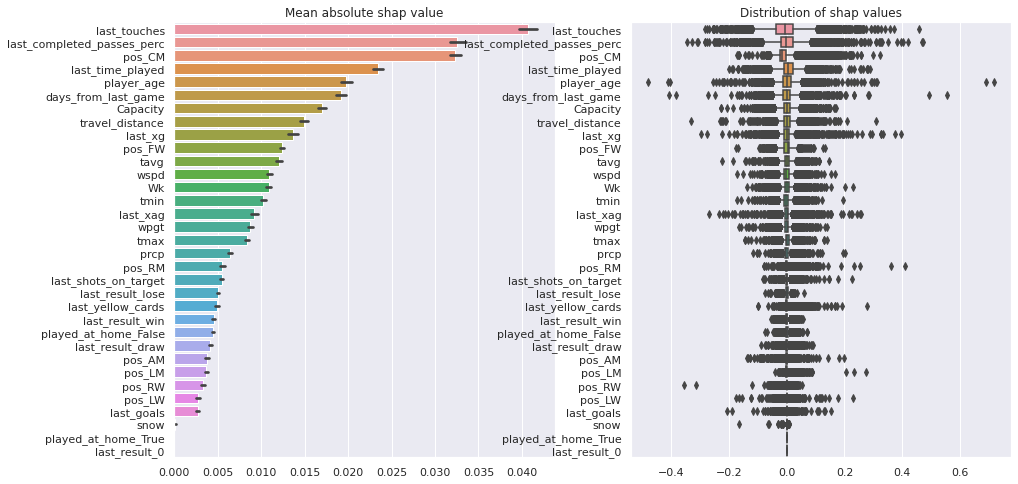

In [104]:
columns = shap_values_df.apply(np.abs).mean().sort_values(ascending=False).index
fig, ax = plt.subplots(1, 2, figsize=(15,8))

sns.barplot(data=shap_values_df[columns].apply(np.abs).values, orient='h', ax=ax[0])
ax[0].set_title("Mean absolute shap value")
ax[0].set_yticklabels(columns)

sns.boxplot(data=shap_values_df[columns].values, orient='h', ax=ax[1])
ax[1].set_title("Distribution of shap values")
ax[1].set_yticklabels(columns);

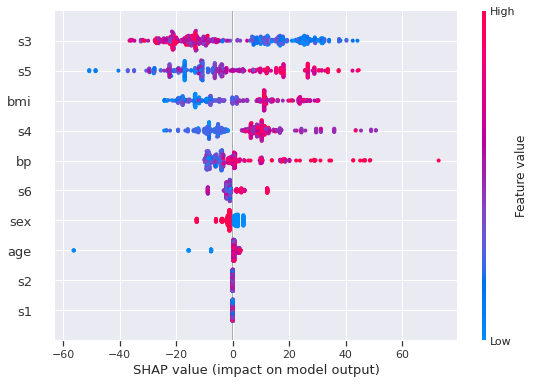

In [72]:
shap.summary_plot(shap_values)

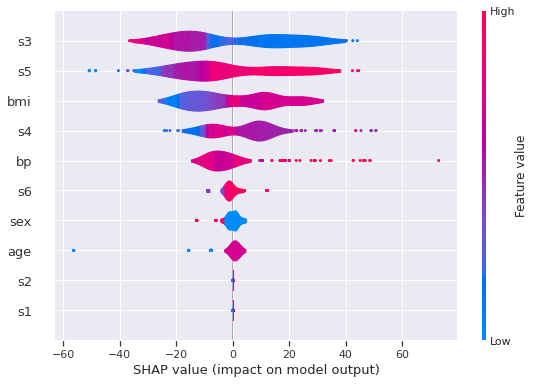

In [73]:
shap.summary_plot(shap_values, plot_type="violin")

In [77]:
shap.force_plot(explainer.expected_value, shap_values.values, X)

In [86]:
class WaterfallData():
    def __init__ (self, shap_test, index):
        self.values = shap_test[index].values
        self.base_values = shap_test[index].base_values[0]
        self.data = shap_test[index].data
        self.feature_names = shap_test.feature_names
        self.display_data = None

def plot_player(shap_values, index):
    shap.plots.waterfall(WaterfallData(shap_values, index))

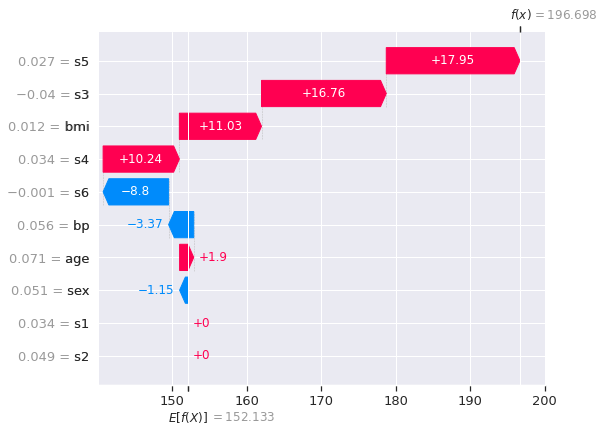

In [87]:
plot_player(shap_values, 0)